In [1]:
# import malconv
import numpy as np
import pandas as pd
import altair as alt
# _ = alt.renderers.enable('notebook')
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.layers import Dense, Conv1D, Activation, GlobalMaxPooling1D, Input, Embedding, Multiply
from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import os

Using TensorFlow backend.
/home/apryor/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/apryor/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/apryor/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/apryor/.local/lib/python3.6/site-packages/tensorflow/python

In [3]:
batch_size = 100
input_dim = 257 # every byte plus a special padding symbol
padding_char = 256


basedir = '/home/apryor/ECE696-AdversarialMalware/malconv/'
if os.path.exists(basedir + 'malconv.h5'):
    print("restoring malconv.h5 from disk for continuation training...")
    model = load_model(basedir + 'malconv.h5')
    _, maxlen, embedding_size = model.layers[1].output_shape
    input_dim
else:
    print("no existing model found...")
    maxlen = 2**20 # 1MB
    embedding_size = 8 
    
    # define model structure
    inp = Input( shape=(maxlen,))
    emb = Embedding( input_dim, embedding_size )( inp )
    filt = Conv1D( filters=128, kernel_size=500, strides=500, use_bias=True, activation='relu', padding='valid' )(emb)
    attn = Conv1D( filters=128, kernel_size=500, strides=500, use_bias=True, activation='sigmoid', padding='valid')(emb)
    gated = Multiply()([filt,attn])
    feat = GlobalMaxPooling1D()( gated )
    dense = Dense(128, activation='relu')(feat)
    outp = Dense(1, activation='sigmoid')(dense)

    model = Model( inp, outp )
    
model.summary()

restoring malconv.h5 from disk for continuation training...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1048576)      0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1048576, 8)   2056        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2097, 128)    512128      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (Non

In [4]:
model.compile(loss='binary_crossentropy', 
              optimizer=SGD(lr=0.01,momentum=0.9,nesterov=True,decay=1e-3), 
              metrics=[metrics.binary_accuracy])

In [5]:
# def filename_to_numpy(filename, maxlen):
#     b = np.ones((maxlen,), dtype=np.uint16) * padding_char
#     bytez = np.fromfile(open(filename, 'rb'), dtype=np.uint8)
#     b[:len(bytez)] = bytez
#     return b

# k_positions = []
# test_files = None
# datadir = '/home/apryor/data/PortableApps/PortableApps-exes/'
# binary_names = []
# for file in os.listdir(datadir):
#     file_size = os.stat(datadir + file).st_size
#     if file_size <= maxlen:
#         binary_names.append(file)
#         exe_bytes = filename_to_numpy(datadir + file, maxlen)
#         k_positions.append(file_size)
#         if test_files is None:
#             test_files = exe_bytes
#         else:
#             test_files = np.vstack((test_files, exe_bytes))
            

In [6]:
# np.save('/home/apryor/data/PortableApps/test_files', test_files)
test_files = np.load('/home/apryor/data/PortableApps/test_files.npy')
# np.save('/home/apryor/data/PortableApps/binary_names', binary_names)
binary_names = np.load('/home/apryor/data/PortableApps/binary_names.npy')
# np.save('/home/apryor/data/PortableApps/k_positions', k_positions)
k_positions = np.load('/home/apryor/data/PortableApps/k_positions.npy')

In [324]:
predictions = model.predict(test_files)
predictions.shape

(618, 1)

In [325]:
# y_classes = predictions.argmax(axis=-1)
# print('y_classes',y_classes)
# initial_class = np.argmax(predictions)
# print('initial_class',initial_class)

In [9]:
print("Likelihood of being malware:")
for i in range(len(predictions)):
    print(f"Confidence: {100.0 * predictions[i][0]:.6f}%")
    if (100.0 * predictions[i][0] > 25):
        print(f"\t{binary_names[i]} is classified as above 25% malicious")

Likelihood of being malware:
Confidence: 0.000635%
Confidence: 0.006980%
Confidence: 0.008810%
Confidence: 99.984586%
	wmaencode.exe is classified as above 25% malicious
Confidence: 0.004700%
Confidence: 1.155478%
Confidence: 0.210729%
Confidence: 0.006509%
Confidence: 0.000381%
Confidence: 0.000104%
Confidence: 0.000024%
Confidence: 0.010172%
Confidence: 0.000802%
Confidence: 0.003591%
Confidence: 0.104696%
Confidence: 30.731028%
	peview.exe is classified as above 25% malicious
Confidence: 0.213730%
Confidence: 0.000986%
Confidence: 0.005463%
Confidence: 0.004148%
Confidence: 0.066096%
Confidence: 0.000995%
Confidence: 0.000000%
Confidence: 0.004011%
Confidence: 0.006217%
Confidence: 0.011313%
Confidence: 0.000057%
Confidence: 0.091356%
Confidence: 0.022379%
Confidence: 99.515033%
	sudoku.exe is classified as above 25% malicious
Confidence: 0.010014%
Confidence: 51.183486%
	chrome_proxy.exe is classified as above 25% malicious
Confidence: 0.190583%
Confidence: 99.998403%
	JkDefragGUI.

In [326]:
# keras.losses.categorical_crossentropy(y_true, y_pred)
# loss = loss_object(input_label, prediction)
# gradient = tape.gradient(loss, input_image)

# def cross_entropy(X,y):
#     X is the output from fully connected layer (num_examples x num_classes)
#     y is labels (num_examples x 1)

file_input shape (1048576,)
x0 shape (1048576,)


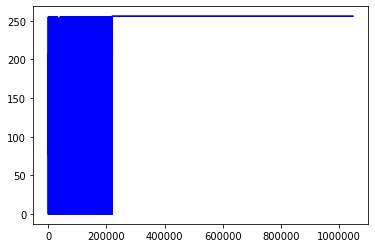

In [327]:
n_sample = 2
file_input = test_files[n_sample]
print('file_input shape',file_input.shape)

x0 = np.reshape(file_input,(np.size(file_input)))
print('x0 shape',np.shape(x0))

plt.plot(x0,'g')
plt.plot(file_input,'b')
plt.show()

Embedding Matrix

In [328]:
get_embedded = K.function([model.layers[0].input],[model.layers[1].output])
byte = 256
mapped_byte = get_embedded(byte)
print('mapped_byte',mapped_byte,np.shape(mapped_byte))

mapped_byte [array([-0.08557673, -0.01154196, -0.14200899,  0.12571388,  0.08277829,
        0.14174102, -0.19375376, -0.16583669], dtype=float32)] (1, 8)


Initalize Variables

In [348]:
# Get current session (assuming tf backend)
sess = K.get_session()
n_sample = 2
file_input = test_files[n_sample]
file_adv = file_input
prob_safe = predictions[n_sample][0]
target_class = 0
n_labels = 1

k = k_positions[n_sample] # k informative bytes / position array
q = 500 # np.size(x) - k # maximum number of padding bytes
T = 10 # maximum number of attack iterations
t = 0
s = 255*[None]
d = 255*[None]

Adversarial Malware Binaries

In [384]:
while t < T: # or prob_safe < 0.5
    t += 1
    for p in range(q):
        j = k + p # to index the padding bytes
    
        weights = model.trainable_weights
        target = K.one_hot(target_class, n_labels)

        # Get the loss and gradient of the loss wrt the weights
        loss = -1*K.categorical_crossentropy(target, model.output)
        grads = K.gradients(loss, weights)

        # Compute the gradient wj
        wj = np.array([1,1,1,1,1,1,1,1])
        nj = np.transpose(wj/np.linalg.norm(wj))

        for i in range(255):
            # Compute zj
            zj = get_embedded(file_adv[j])
            # Compute si
            s[i] = np.dot((np.array(get_embedded(i))-zj),nj)
            # Compute di
            d[i] = np.linalg.norm(np.array(get_embedded(i)) - (zj + s[i]*nj))
        #END-i
            
        # Set xj to argmin d
        xj = np.argmin(np.array(d))
        file_adv[j] = xj
        
        # make prediction
#         xp = np.reshape(file_adv,(1,len(file_adv)))
#         prediction = model.predict(xp)
        
#         prob_safe = prediction
        
    #END-p
#END-t whileloop

KeyboardInterrupt: 

In [320]:
loss = -1*K.categorical_crossentropy(target, model.output)
grads = K.gradients(loss, weights)

In [352]:
grads

 <tf.Tensor 'gradients_1637/conv1d_1/convolution/ExpandDims_1_grad/Reshape:0' shape=(500, 8, 128) dtype=float32>,
 <tf.Tensor 'gradients_1637/conv1d_1/Reshape_grad/Reshape:0' shape=(128,) dtype=float32>,
 <tf.Tensor 'gradients_1637/conv1d_2/convolution/ExpandDims_1_grad/Reshape:0' shape=(500, 8, 128) dtype=float32>,
 <tf.Tensor 'gradients_1637/conv1d_2/Reshape_grad/Reshape:0' shape=(128,) dtype=float32>,
 <tf.Tensor 'gradients_1637/dense_1/MatMul_grad/MatMul_1:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'gradients_1637/dense_1/BiasAdd_grad/BiasAddGrad:0' shape=(128,) dtype=float32>,
 <tf.Tensor 'gradients_1637/dense_2/MatMul_grad/MatMul_1:0' shape=(128, 1) dtype=float32>,
 <tf.Tensor 'gradients_1637/dense_2/BiasAdd_grad/BiasAddGrad:0' shape=(1,) dtype=float32>]

In [387]:
delta = K.sign(grads[1])

In [395]:
delta[1,:,1]

<tf.Tensor 'strided_slice_92:0' shape=(8,) dtype=float32>

In [399]:
mytf = np.array([1,1,1,1,1,1,1,1]) + delta[1,:,1]

In [412]:
mytf2 = mytf / tf.math.l2_normalize(mytf)

In [414]:
np.dot(mytf2,(np.array(get_embedded(i))-zj))

array([[<tf.Tensor 'mul_2684:0' shape=(8,) dtype=float32>,
        <tf.Tensor 'mul_2685:0' shape=(8,) dtype=float32>,
        <tf.Tensor 'mul_2686:0' shape=(8,) dtype=float32>,
        <tf.Tensor 'mul_2687:0' shape=(8,) dtype=float32>,
        <tf.Tensor 'mul_2688:0' shape=(8,) dtype=float32>,
        <tf.Tensor 'mul_2689:0' shape=(8,) dtype=float32>,
        <tf.Tensor 'mul_2690:0' shape=(8,) dtype=float32>,
        <tf.Tensor 'mul_2691:0' shape=(8,) dtype=float32>]], dtype=object)

In [417]:
np.shape((np.array(get_embedded(i))-zj))

(1, 8)